### Submition for 
## ARM: Data Challenge
#### by Bilgin Sherifov
Date: 2019-08-13

Packages to install before running the notebook:

1. Python 3.x
3. Numpy
4. Matplotlib
5. Seaborn
6. Contextlib
7. Scipy

(python -m pip install --user numpy matplotlib seaborn contextlib)

## Note on running the notebook:

The notebook should be ran in the <i>~/src</i> folder.

In [1]:
# numpy and pandas
import numpy as np

# import plotting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set(); 
%matplotlib inline

# time-related libraries
import time as tm

# system and OS libraries
import os
from os.path import join as pj
import copy


#MSCL
from contextlib import contextmanager
import warnings
import itertools
from itertools import chain

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

sns.set_context("talk") # paper, notebook, talk, poster


# SOME CORE FUNCTIONS / CLASSES

In [2]:
@contextmanager
def timer(title, n_blanks = 1):
    print(n_blanks * ' ' + 'STARTING: {}'.format(title))
    t0 = tm.time()
    yield
    print(n_blanks * ' ' + "FINISHED in {:.2f} min. \n".format((tm.time() - t0)/60))
    
def interpolate_histogram_zeros(x):
    n_bins = len(x)
    idx_zeros = np.where(hist == 0)[0]
    for idx in idx_zeros:
        if idx == 0:
            slope = x[idx+2] - x[idx+1]
            x[idx] = np.max([1, x[idx+1] - slope])
        elif idx == n_bins:
            slope = x[idx-1] - x[idx-2]
            x[idx] = x[idx-1] + slope
        else:
            x[idx] = int(0.5 * (x[idx-1] + x[idx+1]))
            
    return x
    
def rgb2gray(x):
    #  Grayscale = 0.2989 R + 0.5870 G + 0.1140 B 
    x_gray = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])
    x_gray *= 255 / x_gray.max()
    return x_gray

# Set Paths

In [3]:
if False:
    PATHS = {'root' : os.getcwd()}

    for new_path in ['data', 'results', 'WORKSPACE', 'info']:
        os.mkdir(pj(PATHS['root'], new_path))
        PATHS[new_path] = pj(PATHS['root'], new_path)
else:
    #os.chdir("..")
    os.chdir(os.path.dirname(os.getcwd()))
    PATHS = {'root' : os.getcwd()}
    for new_path in ['data', 'results', 'WORKSPACE', 'info', 'src']:
        PATHS[new_path] = pj(PATHS['root'], new_path)
[print(key,':', val) for key, val in PATHS.items()];

src : E:\JupyterNB\Job Applications\Arm\src
WORKSPACE : E:\JupyterNB\Job Applications\Arm\WORKSPACE
root : E:\JupyterNB\Job Applications\Arm
data : E:\JupyterNB\Job Applications\Arm\data
info : E:\JupyterNB\Job Applications\Arm\info
results : E:\JupyterNB\Job Applications\Arm\results


# Explore the data:

1. Load and show a noisy version of the <i>"cameraman"</i> image
2. Plot the histogram (empirical probability density function, pdf) of its pixels' gray values, along with the cumilative distribution (cdf)

 STARTING: Loading the noisy image
 FINISHED in 0.00 min. 

 STARTING: Calculating histograms


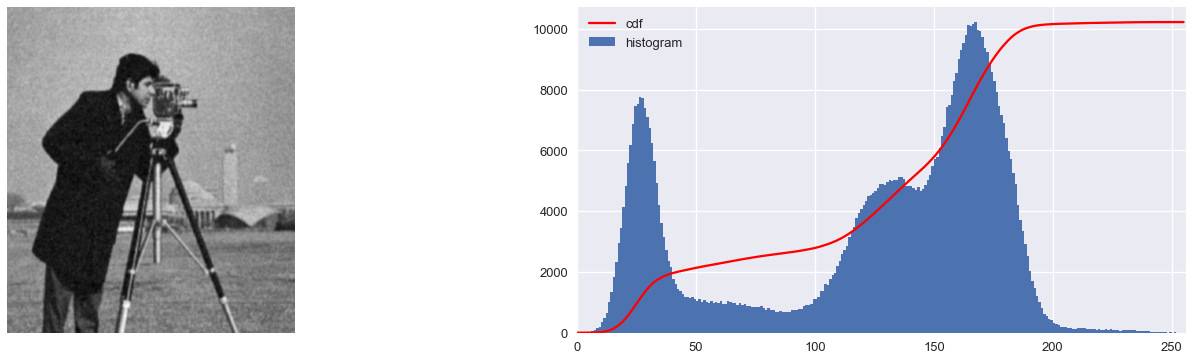

 FINISHED in 0.01 min. 



In [4]:
# image and processing
#import cv2
#from PIL import Image

#import scipy.ndimage
#import skimage
#from skimage.transform import resize
#from skimage.feature import local_binary_pattern
#from skimage.io import imread, imshow, concatenate_images
#from skimage.transform import resize
#from skimage.morphology import label

with timer('Loading the noisy image'):
    img_path_name = pj(PATHS['data'], 'noisy_cameraman_image.png')
    img = rgb2gray(plt.imread(img_path_name)).astype('uint16')
    #img_2 = cv2.imread(img_path_name,0)
    #img = Image.open(img_path_name).convert('LA')
    
with timer('Calculating histograms'):
    hist, bins = np.histogram(img.flatten(),256,[0,256])
    # interpolate bins with zero vlues
    hist = interpolate_histogram_zeros(hist)
    
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    
    plt.close('all')
    plt.figure(figsize=(24,6))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.subplot(1,2,2)
    plt.bar(bins[1:], height = hist, width =1.0, align = 'edge', linewidth = 0)
    plt.xlim([0,256])
    plt.plot(cdf_normalized, c='red')
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

# Method 1: Zero-ccrossing of the first derivative

The peak values in a signal are places where the first derivative of the signal turns from positive to negative.  Thus, a classical method for detecting local peaks in a signal is to detect the zero-crossings of its first derivative.  Pekas are also points where the secon-derivative of the signal has large negative value (or, the curvature of the signal at the peak location should be convex, i.e. downward concave).  However, since the derivative operator amplifies noise (small high-frequency variations), it's a good idea to smooth out these by first low-pass filtering the signal to which the derivative is to be applied.

1. Smooth the histogram with a low-pass filter to remove high-frequency varition.  Here I use a Gaussian kernel.
<br/><br/>
2. Take the first derivative (gradient) of the smoothened histogram (call it grad_1).  Here I use the <i>[1, 0, -1]</i> kernel.
<br/><br/>
3. Smooth out the first derivative with the same low-pass filter to remove high-frequency varition. 
<br/><br/>
4. Take the second derivative (gradient) of the smoothened histogram (call it grad_2).  This is done by applying the <i>[1, 0, -1]</i> discrete derivative kernel to the smoothened version of the first derivative
<br/><br/>
5. Smooth out the second derivative with the same low-pass filter to remove high-frequency varition.
<br/><br/>
The sequential linear processes of first smoothing a signal, then taking its derivative, and then smoothing it again could be achieved by a convolution with a single kernel, which is derived by convolving the smoothing kernel with the derivative kernel and then convlving it again with the smoothing kernel.  Then steps 1., 2. and 3. above become a singe step, as do steps 4. and 5.
<br/><br/>
7.  The peak detection algorithm looks at these three conditions to decide where the peak is:
  - The first derivative of the signal at peak locations should be zero.  Furthermore, to make sure it is not a valley, the first derivative should be positive before the peak and negative after it.  So, one should detect positive-to-negative zero-crossing of the first derivative.  To do this, take the sign of the derivative, then take the differenece between consequitive values and look find all negative values in the final signal.
  - To be a peak, the signal value should be substantially higher than most of the other signal points.  Therefore, I set a condition that its value should be in the top 25th percentile.
  - The curvature of the signal at the peak location should be convex (downward concave), thus it should have a very negative second derivative. Therefore, I set a condition that its value should be in the bottom 25th percentile.

## Build the first peak detector

In [6]:
from scipy import signal

def find_peaks_dog(x, len_smoothing_kernel = 7, scale_smoothing_kernel = 3):
    
    # build a smoothing kernel
    krnl_smooth = np.exp(-(np.linspace(-2,2,len_smoothing_kernel)**2) / scale_smoothing_kernel)
    krnl_smooth = krnl_smooth / np.sum(krnl_smooth)
    
    # build a derivative or gradient kernel
    krnl_grad = np.array([1,0,-1]) 
    
    # build a single kernel that is equivalent of first smoothing the signal, then taking its derivative, and then smoothing it again
    # build two such derivative kernels: one ofr the first derivative and one for the second derivative
    krnl_smth_grad_1 = signal.convolve(signal.convolve(krnl_smooth, krnl_grad), krnl_smooth)
    krnl_smth_grad_2 = signal.convolve(signal.convolve(krnl_smth_grad_1, krnl_grad), krnl_smooth)
    
    # Smooth the signal with a low-pass filter to remove high-frequency varition
    x_smth = signal.convolve(x, krnl_smooth, mode='same')
        
    # take the smoothened first derivative of the signal
    x_grad_1 = signal.convolve(x, krnl_smth_grad_1, mode='same')
    
    # take the smoothened second derivative of the signal
    x_grad_2 = signal.convolve(x, krnl_smth_grad_2, mode='same')
    
    # detect peaks by looking at three conditions:
    #  - The derivative crosses the zero from negative to pozitive
    #  - The signal value is at least in the top 25 percentile
    #  - Has a very low negative second derivative (in the bottom 25 percentile)
    idx_peaks = np.where(
        (np.diff(np.sign(x_grad_1)) < 0) # zero-crossings of derivative, from + to -
        & (np.abs(x)[1:] > np.percentile(x, 75)) #high signal value
        & (x_grad_2[1:] < np.percentile(x_grad_2, 25)) # very negative second derivative
        
    )[0]
    
    return idx_peaks, x_smth, x_grad_1, x_grad_2

## Pass the histogram to the first peak detector and plot results

<b>Note:</b> my original smoothing kernel is of size 5, to allow smoother transition from zero to max value, thus less ripple effect in frequency domain.

 STARTING: Detecting peaks via zero crossings of the gradient
 FINISHED in 0.00 min. 

Peak Locations  Peak Values:
----------------------------
            25          7775
           133          5037
           165         10159


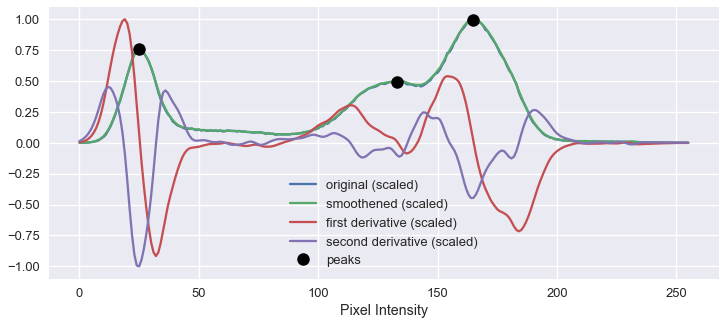

In [7]:
with timer('Detecting peaks via zero crossings of the gradient'):
    idxPeaks, xSmth, xGrad_1, xGrad_2 = find_peaks_dog(hist, len_smoothing_kernel = 5, scale_smoothing_kernel = 10)

plt.close('all')
plt.figure(figsize=(12,5))
plt.plot(hist / hist.max(), label = 'original (scaled)')
plt.plot(xSmth / xSmth.max(), label = 'smoothened (scaled)')
plt.plot(xGrad_1 / np.max(np.abs(xGrad_1)), label = 'first derivative (scaled)')
plt.plot(xGrad_2 / np.max(np.abs(xGrad_2)), label = 'second derivative (scaled)')
plt.plot(idxPeaks, hist[idxPeaks] / hist.max(), '.', markersize=25, c='k', label = 'peaks')
#plt.ylabel("Frequency")
plt.xlabel("Pixel Intensity")
plt.legend()

print('Peak Locations  Peak Values:')
print(28 * '-')
[print('{0:>14d} {1:>13d}'.format(idx, hist[idx])) for idx in idxPeaks];

# Method 2: Fit a mixture of Gaussians

Another method to identify peaks in an image histogram is to fit a Gaussian Mixture Model (GMM) to estimate the probability distribution of the gray values of the image.  In GMM the probability distribution $p(\boldsymbol{x})$ is approximated with the sum of $K$ Gaussian components, $\mathcal{N}(\boldsymbol{\mu_i,\Sigma_i})$, each weighed by weight $\pi_i$:
$$
p(\boldsymbol{x}) = \sum_{i=1}^K\pi_i \mathcal{N}(\boldsymbol{\mu_i,\Sigma_i})
$$
1. The peak locations are the means (centers) of each Gaussian component.
<br/><br/>
2. Typically one uses the Expectation Maximisation (EM) algorithm to estimate the location, scale, and weight parameters. In EM, for the GMM case, one first (the E step) calculates the expectation of each data point for each Gaussian component, given the current set of parameters.  Then (the M step), one maximises the expectations calculated in the previous step, thus updating the model parameters.  One keeps iterating between these two stages until certain level of convergence is reached,
<br/><br/>
3. Noramlly one has to decide beforehand the number of mixture components.  This could be optimised by fitting models with various number of mixtures and using AIC and BIC-like criteria to select the optimum number of components.  Here I also add my own criterion on top of BIC and AIC (explained below)
<br/><br/>
4. Also, since it is an iterative proces, initial prameters might greatly influence the end result.  Starting with k-means clustering for location and covariance estimation is typical.
<br/><br/>

## Build the GMM peak detector

In [32]:
from sklearn import mixture

def fit_gmm(img, n_compnents = 10, tol=1e-4, max_iter = 500, n_init = 5):
    
    # build a GMM model
    mdl = mixture.GaussianMixture(n_components=n_compnents, covariance_type='diag', tol=tol)
    # fit the model
    mdl.fit(np.expand_dims(img.flatten(),1))
        
    return mdl


def find_peaks_gmm(img, histogram_, n_compnents = 10, tol=1e-4, max_iter = 500, n_init = 5, max_percentile = 0.9):
    
    # best fit is with seems to be with 7 components
    mdl = fit_gmm(img, n_compnents = n_compnents, tol=tol)

    # build a criterion based on weights and variances
    criterion = mdl.weights_ * histogram_[mdl.means_.astype(int).flatten()] / mdl.covariances_.flatten()
    criterion /= criterion.sum()
    # get idx of sorted components
    idx_sorted_components = np.argsort(criterion)[::-1]
    # sort criterion
    criterion = np.sort(criterion)[::-1]
    # take the cumulative sum of the sorted criterion
    criterion_sum = criterion.cumsum()
    # select only those components that account for 90% of the totl criterion score.
    idx_sorted_components = idx_sorted_components[np.where(criterion_sum <= max_percentile)[0]]
    # get peak locations
    idx_peaks = mdl.means_.astype(int).flatten()[idx_sorted_components]
        
    return idx_peaks, mdl

## Pass the image gray values to the GMM model and try different number of components

In [9]:
with timer('Searching best number of GMM components'):
    x = np.linspace(0,255,256).reshape(-1, 1)
    print(4*' ' + 'n_comps  BIC  AIC')
    print(4*' ' + 17 * '-')
    for n_compnents in range(2,8):
        gmm = fit_gmm(img, n_compnents = n_compnents)
        print(4*' ' + '{0:>7d} {1:4d} {2:4d}'.format(n_compnents, int(gmm.bic(x)), int(gmm.aic(x))))

 STARTING: Searching best number of GMM components
    n_comps  BIC  AIC
    -----------------
          2 3310 3293
          3 3408 3379
          4 3894 3855
          5 3602 3552
          6 3526 3466
          7 3510 3439
 FINISHED in 1.10 min. 



## Choose the model that gives the best BIC score and show results

According to BIC and AIC criteria, for this runt he best fit is with 4 components (sometimes it says with 7).  But usually not all of the components are peaks.  One would expect that only components with narrower variances and significant weights woud be peaks.

A good criterion would be to use the product of the weights and the inverse of the variances and of the empirical density at the means.  Then, one could select only those components that score above certain threshold on this criterion.  Or, one could sort the compnents according to this criterion and select the top N cmponents that account for 90% of the total criterion score, for example. This is waht I'm doing in the code above (find_peaks_gmm):

1.  Fit GMM with 7 compnents
2.  Build a criterion based on weights and variances and empirical density 
3.  Sort compnents in descending order ccording to this criterion
4.  Select only the top N components that account for 90% of the totl criterion score.

 STARTING: Detecting peaks via GMM
 FINISHED in 0.57 min. 



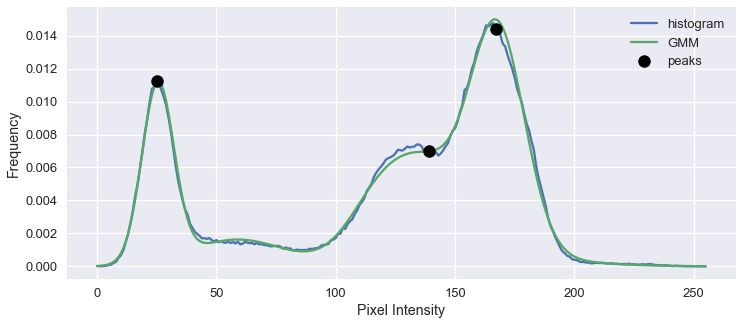

Peak Locations  Peak Values:
----------------------------
            25          7775
           167          9966
           139          4830


In [35]:
with timer('Detecting peaks via GMM'):
    idxPeaks, gmm = find_peaks_gmm(img, hist, n_compnents = 6, tol=1e-5, max_iter = 100, n_init = 10, max_percentile = 0.95)

    
x = np.linspace(0,255,256).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

# Plot histograms and gaussian curves
plt.close('all')
plt.figure(figsize=(12,5))
plt.plot(hist / hist.sum(), label = 'histogram')
plt.plot(x, y, label="GMM")
plt.ylabel("Frequency")
plt.xlabel("Pixel Intensity")
plt.plot(idxPeaks, hist[idxPeaks] / hist.sum(), '.', markersize=25, c='k', label = 'peaks')
plt.legend()
plt.show()

print('Peak Locations  Peak Values:')
print(28 * '-')
[print('{0:>14d} {1:>13d}'.format(idx, hist[idx])) for idx in idxPeaks];